# KOH Posterior Analysis using Mici

In [30]:
from models import toymodel_sin as KOHmodel
from data.dataloader import DataLoader
from kohgpjax.mappings import mapRto01, map01toR, mapRto0inf, map0inftoR
from jax import jit, grad

import numpy as np
import matplotlib.pyplot as plt

import mici
import arviz

from truefuncs import zeta
eta = zeta

plot_style = {
    'mathtext.fontset': 'cm',
    'font.family': 'serif',
    'axes.titlesize': 10,
    'axes.labelsize': 10,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'legend.fontsize': 8,
    'legend.frameon': False,
    'axes.linewidth': 0.5,
    'lines.linewidth': 0.5,
    'axes.labelpad': 2.,
    'figure.dpi': 150,
}

# The data

In [31]:
dataloader = DataLoader('data/toy/field_sin.csv', 'data/toy/sim_sin.csv')
data = dataloader.get_data()
model = KOHmodel.Model(*data)

tmax = dataloader.t_max
tmin = dataloader.t_min

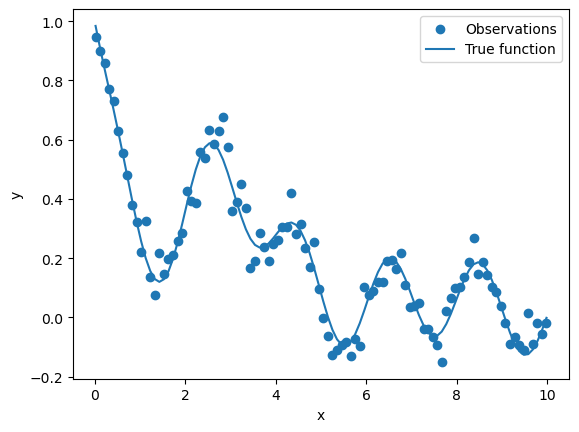

In [32]:
fig, ax = plt.subplots(1, 1)
ax.scatter(dataloader.xf, dataloader.yf, label='Observations')
def disc(x):
    return 0.14*np.sin(x*np.pi)
ax.plot(dataloader.xf, zeta(dataloader.xf, 0.4)+disc(dataloader.xf), label='True function')
# for t in [0.2, 0.3, 0.4, 0.5, 0.6]:
#     rows = dataloader.tc==t
#     ax.plot(dataloader.xc[rows], dataloader.yc[rows], '--', label=f'Simulator t={t}')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
plt.show()

# MCMC Setup

In [33]:
theta_0 = 0.5

ell_eta_0_0 = 1 # np.sqrt(np.var(dataloader.xf))/3
ell_eta_1_0 = 0.3 # np.sqrt(np.var(dataloader.tc))/3
ell_delta_0_0 = 2 # np.sqrt(np.var(dataloader.xf))/5

lambda_eta_0 = 1
lambda_delta_0 = 30
lambda_epsilon_0 = 400
lambda_epsilon_eta_0 = 10000

period_delta_0 = 2

init_states = np.array([[
    map01toR(theta_0), 
    map0inftoR(ell_eta_0_0),
    map0inftoR(ell_eta_1_0),
    map0inftoR(ell_delta_0_0),
    map0inftoR(lambda_eta_0),
    map0inftoR(lambda_delta_0),
    map0inftoR(lambda_epsilon_0),
    map0inftoR(lambda_epsilon_eta_0),
    map0inftoR(period_delta_0)
]])

Build the transform function to translate Mici's unbounded parameters into bounded GPJAX parameters.
This is passed to KOHGPJax.

In [34]:
param_transform_mici_to_gpjax = lambda x: [
    [ # theta (calibration) parameters
        mapRto01(x[0]),
    ],
    [ # lengthscale parameters
        mapRto0inf(x[1]), 
        mapRto0inf(x[2]), 
        mapRto0inf(x[3]),
    ],
    [ # lambda (variance) parameters
        mapRto0inf(x[4]), 
        mapRto0inf(x[5]), 
        mapRto0inf(x[6]), 
        mapRto0inf(x[7]),
    ],
    [ # periodicity parameter
        mapRto0inf(x[8]),
    ]
]

Build the function for evaluating the negative log posterior density.

This function is jitted and grad jitted using JAX. Finally the JAX functions are wrapped into a numpy function for clean interactions with Mici.

In [35]:
jitted_neg_log_posterior_density = jit(
    model.get_KOH_neg_log_pos_dens_func(
        param_transform_mici_to_gpjax
    )
)
grad_neg_log_posterior_density = jit(grad(
    model.get_KOH_neg_log_pos_dens_func(
        param_transform_mici_to_gpjax
    )
))

def neg_log_pos_dens(x):
    return np.asarray(jitted_neg_log_posterior_density(x))

def grad_neg_log_pos_dens(x):
    return np.asarray(grad_neg_log_posterior_density(x))

##### Mici #####
system = mici.systems.EuclideanMetricSystem(
    neg_log_dens=neg_log_pos_dens,
    grad_neg_log_dens=grad_neg_log_pos_dens,
)
integrator = mici.integrators.LeapfrogIntegrator(system)

# Running MCMC algorithm

In [36]:
seed = 1234
n_chain = 1
n_warm_up_iter = 200
n_main_iter = 500
rng = np.random.default_rng(seed)

##### Mici sampler and adapters #####
# sampler = mici.samplers.StaticMetropolisHMC(system, integrator, rng, n_step=3)
sampler = mici.samplers.DynamicMultinomialHMC(system, integrator, rng) # "STAN algorithm"
adapters = [
    mici.adapters.DualAveragingStepSizeAdapter(0.8),
    mici.adapters.OnlineCovarianceMetricAdapter()
]

def trace_func(state):
    return {
        'm_theta': state.pos[0], 
        'm_ell_eta_0': state.pos[1], 
        'm_ell_eta_1': state.pos[2],
        'm_ell_delta_0': state.pos[3],
        'm_lambda_eta': state.pos[4],
        'm_lambda_delta': state.pos[5],
        'm_lambda_epsilon': state.pos[6],
        'm_lambda_epsilon_eta': state.pos[7],
        'm_period': state.pos[8],
        'hamiltonian': system.h(state)
    }

final_states, traces, stats = sampler.sample_chains(
    n_warm_up_iter, 
    n_main_iter, 
    init_states, 
    adapters=adapters, 
    n_process=n_chain, # only 1 works on MacOS
    trace_funcs=[trace_func]
)

Sampling stage: Initial fast adaptive [10:38] > Slow adaptive (1/2) [06:42] > Slow adaptive (2/2) [00:49] > Final fast adaptive [01:01] > Main non-adaptive [07:42]

Chain 1/1: 100%|██████████|500/500 [07:42<00:00, 1.08it/s, accept_stat=0.931]

# Analyse MCMC output

In [37]:
arviz.summary(traces)

Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
m_theta,0.416,0.039,0.347,0.492,0.002,0.001,351.0,358.0,NaN
m_ell_eta_0,0.774,0.035,0.716,0.845,0.001,0.001,553.0,369.0,NaN
m_ell_eta_1,-1.294,0.041,-1.373,-1.221,0.002,0.001,430.0,243.0,NaN
m_ell_delta_0,0.296,0.329,-0.285,0.920,0.012,0.010,746.0,333.0,NaN
m_lambda_eta,-1.198,0.324,-1.820,-0.597,0.015,0.011,456.0,374.0,NaN
m_lambda_delta,3.231,0.331,2.651,3.838,0.015,0.011,483.0,405.0,NaN
m_lambda_epsilon,5.961,0.135,5.707,6.202,0.006,0.004,560.0,374.0,NaN
m_lambda_epsilon_eta,12.220,0.067,12.093,12.343,0.003,0.002,631.0,468.0,NaN
m_period,0.683,0.006,0.672,0.693,0.000,0.000,601.0,398.0,NaN
hamiltonian,-2243.596,3.113,-2248.564,-2237.603,0.226,0.160,189.0,358.0,NaN


In [38]:
for var, trace in traces.items():
    print(var, ": ", np.mean(trace[0]), '±', np.std(trace[0]))

m_theta :  0.4163950258152107 ± 0.038922450982760065
m_ell_eta_0 :  0.77350788665348 ± 0.0348028818302235
m_ell_eta_1 :  -1.2941943759890224 ± 0.040520263077129325
m_ell_delta_0 :  0.29635458320085867 ± 0.3285970674238853
m_lambda_eta :  -1.1981407621849836 ± 0.32373020992337503
m_lambda_delta :  3.230617751746626 ± 0.33082969846388116
m_lambda_epsilon :  5.960771650441706 ± 0.13514337326015724
m_lambda_epsilon_eta :  12.220492212311198 ± 0.06739602688481054
m_period :  0.6828540004102799 ± 0.005787655896649698
hamiltonian :  -2243.5957965167045 ± 3.109920522597045


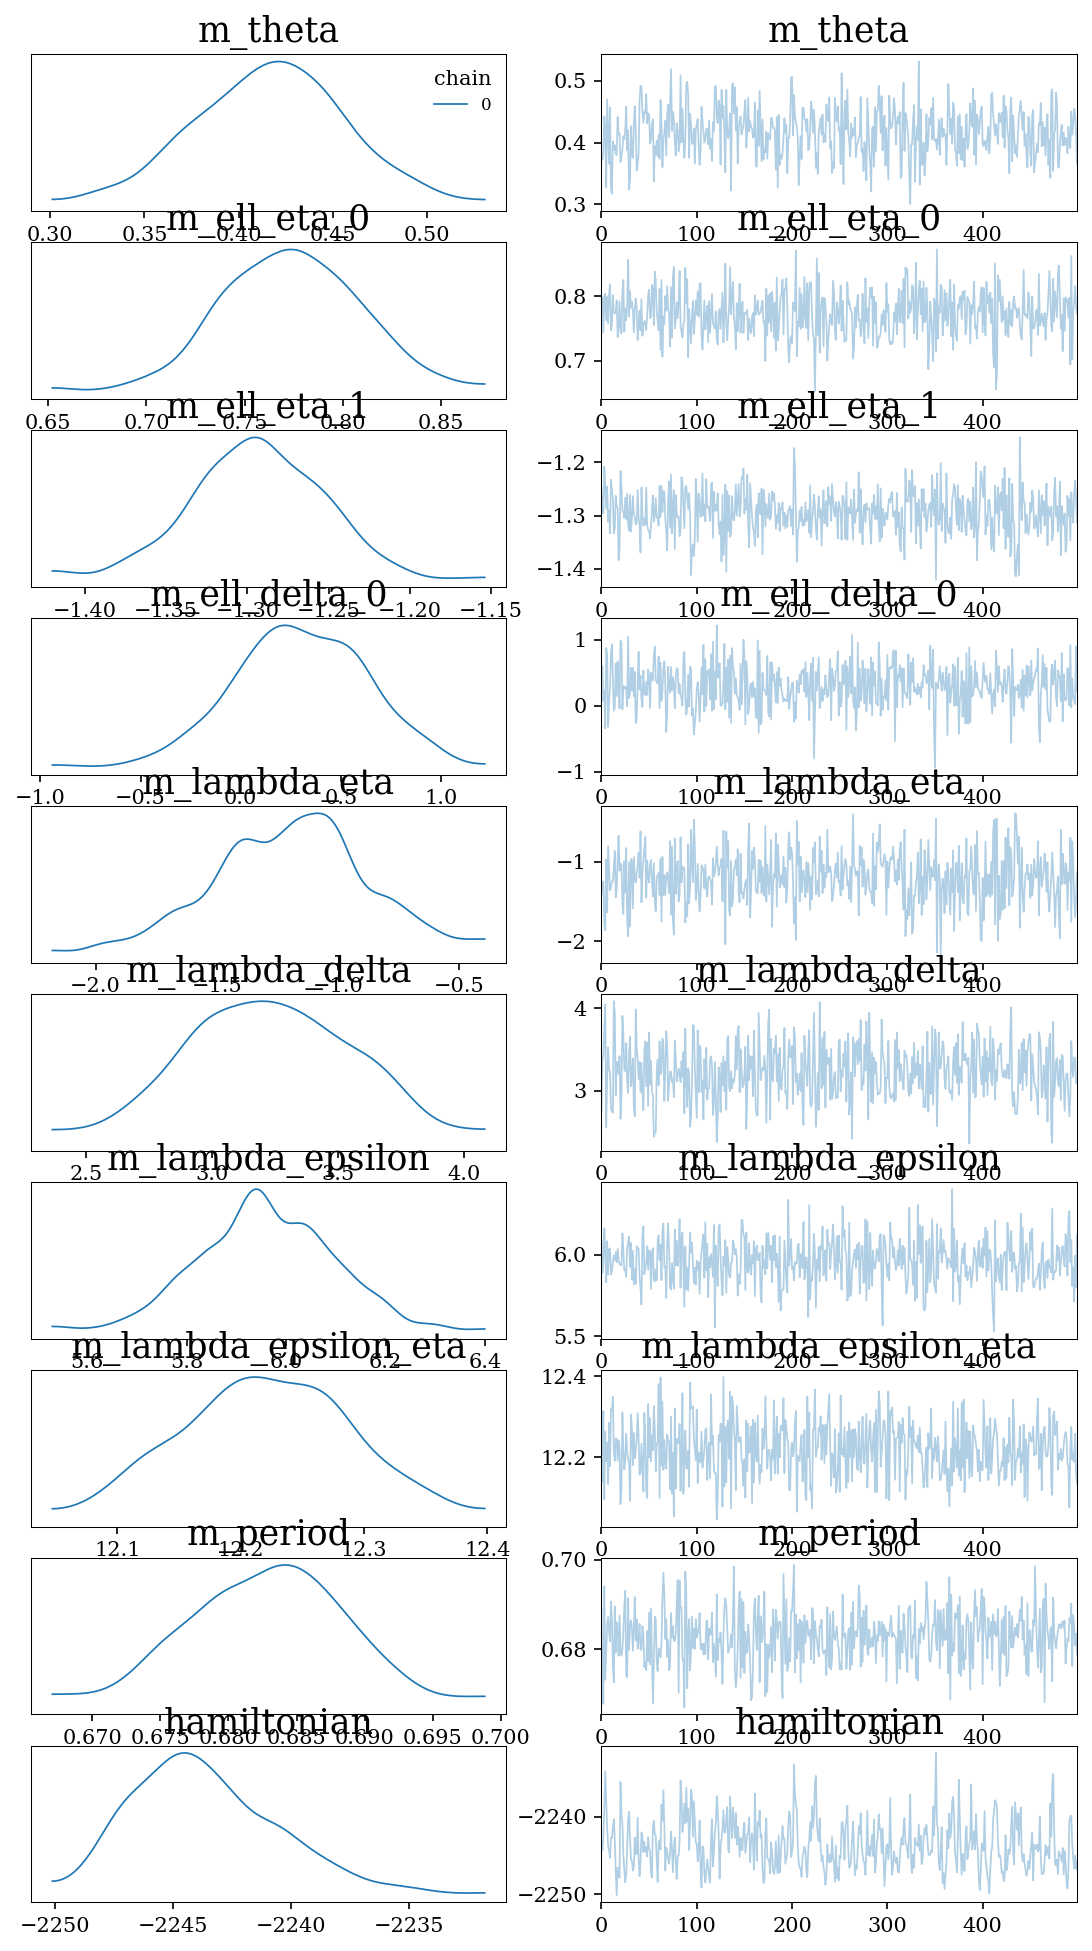

In [39]:
with plt.style.context(plot_style):
    arviz.plot_trace(
        traces,
        # var_names=["σ", "ϵ", "γ", "β", "x_0"],
        figsize=(9, 2 * (8)),
        legend=True,
        compact=False,
    )


# Transform the Chains

In [40]:
traces_transformed = {}
for var, trace in traces.items():
    if var == 'hamiltonian':
        continue
    var_name = var.split('m_')[1]
    if var_name == 'theta':
        traces_transformed[var_name] = mapRto01(trace[0])*(tmax-tmin) + tmin
    elif var_name.startswith('ell'):
        traces_transformed[var_name] = mapRto0inf(trace[0])
    elif var_name.startswith('lambda'):
        traces_transformed[var_name] = mapRto0inf(trace[0])
    elif var_name == 'period':
        traces_transformed[var_name] = mapRto0inf(trace[0])

params_transformed = {}
for var, trace in traces_transformed.items():
    params_transformed[var] = np.mean(trace)
    print(var, ": ", np.mean(trace), '±', np.std(trace))

theta :  0.39727958474651054 ± 0.008373884988467716
ell_eta_0 :  2.168668189290114 ± 0.07545062862217561
ell_eta_1 :  0.27434335411125677 ± 0.011093189779572217
ell_delta_0 :  1.4181080681590734 ± 0.4641991057604598
lambda_eta :  0.317755041050435 ± 0.10319424327770838
lambda_delta :  26.714970001943772 ± 8.986498010794305
lambda_epsilon :  391.46617308311573 ± 53.126523566133926
lambda_epsilon_eta :  203366.16234265646 ± 13717.885351305711
period :  1.979552377179946 ± 0.011455134255431562


In [41]:
arviz.summary(traces_transformed)

Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.397,0.008,0.381,0.412,0.000,0.000,351.0,358.0,NaN
ell_eta_0,2.169,0.076,2.046,2.329,0.003,0.002,553.0,369.0,NaN
ell_eta_1,0.274,0.011,0.252,0.294,0.001,0.000,430.0,243.0,NaN
ell_delta_0,1.418,0.465,0.640,2.304,0.017,0.012,746.0,333.0,NaN
lambda_eta,0.318,0.103,0.136,0.504,0.005,0.004,456.0,374.0,NaN
lambda_delta,26.715,8.995,13.013,44.053,0.404,0.291,483.0,405.0,NaN
lambda_epsilon,391.466,53.180,300.909,493.574,2.207,1.561,560.0,374.0,NaN
lambda_epsilon_eta,203366.162,13731.624,178642.762,229258.059,556.177,402.578,631.0,468.0,NaN
period,1.980,0.011,1.959,2.000,0.000,0.000,601.0,398.0,NaN


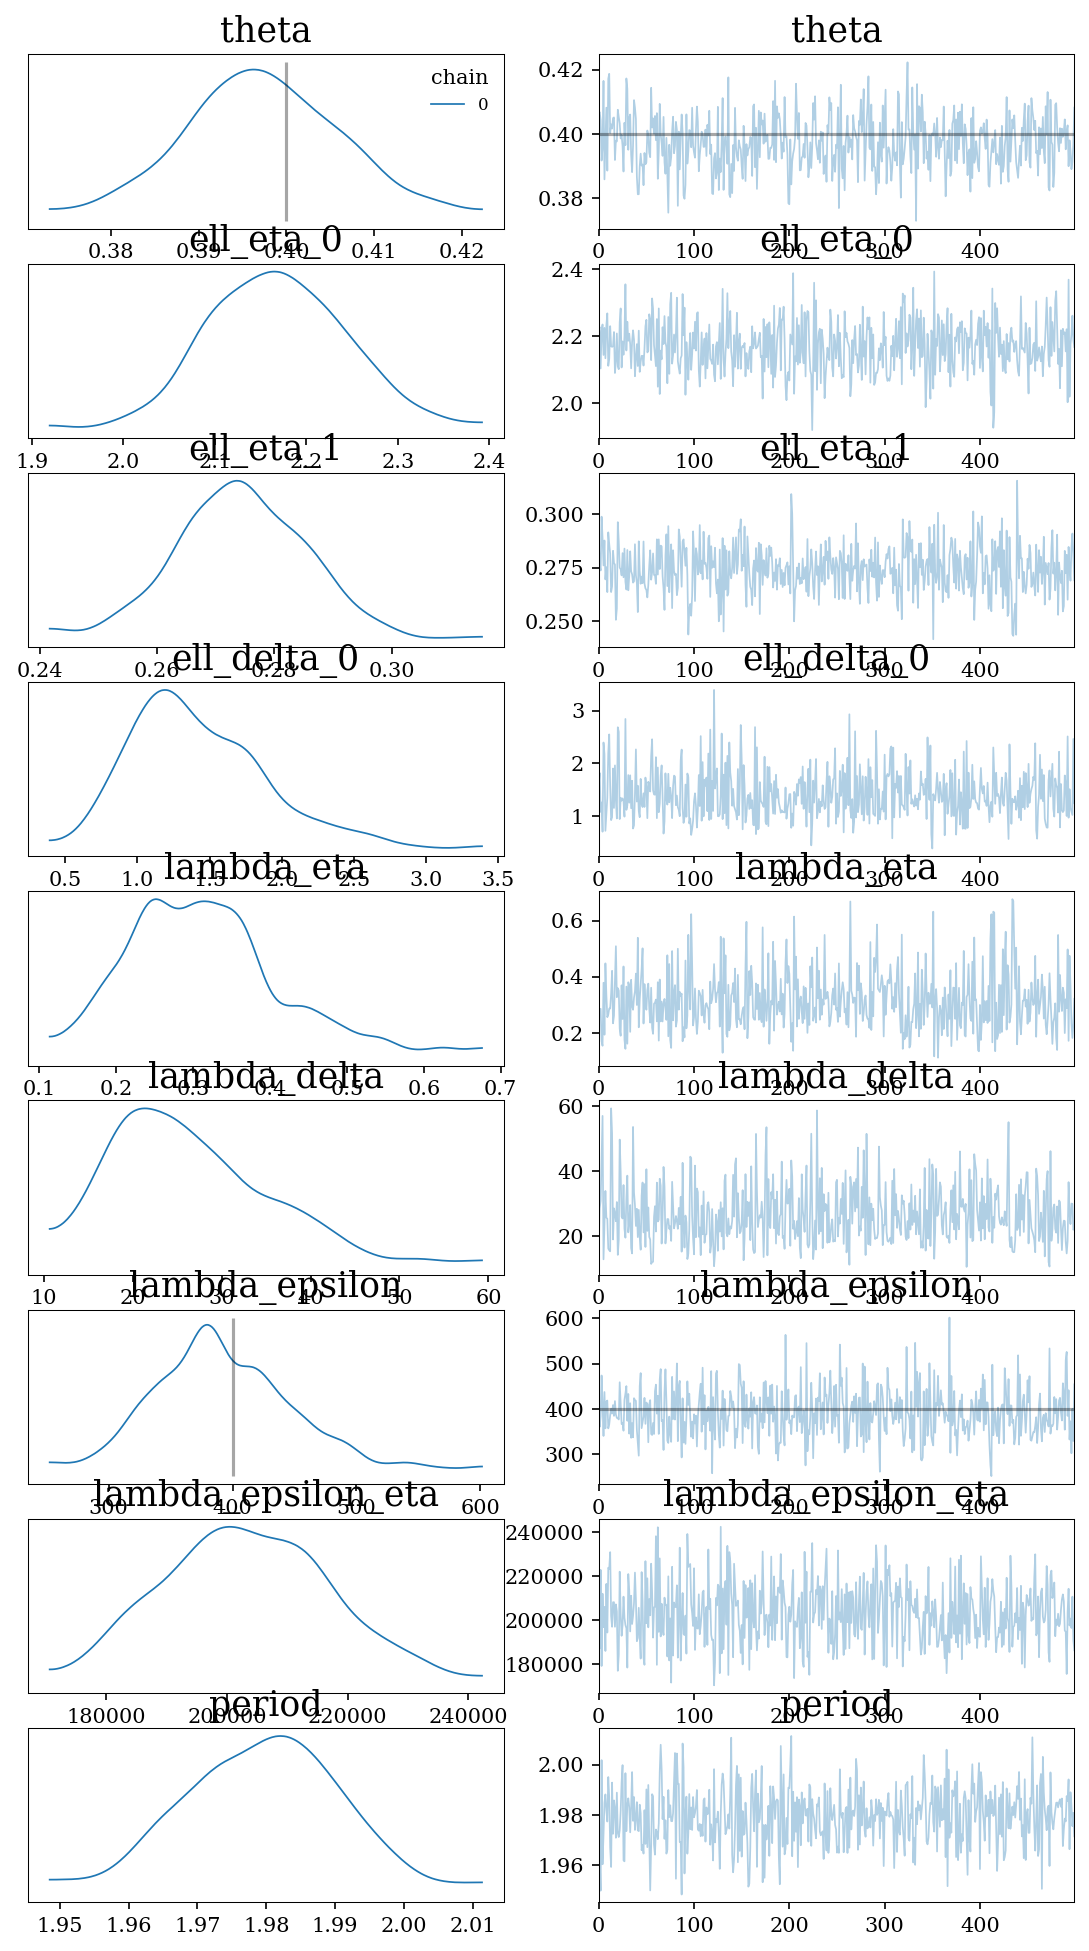

In [42]:
with plt.style.context(plot_style):
    arviz.plot_trace(
        traces_transformed,
        figsize=(9, 2 * (8)),
        legend=True,
        compact=False,
        lines=(
            ('theta', {}, 0.4),
            ('lambda_epsilon', {}, 1/0.05**2)    
        )
    )
plt.show()

# Analyse posterior fit

## Prediction data

In [43]:
posterior_eta_predictions = np.loadtxt("data/matlab/posterior_eta_predictions.csv", delimiter=",", dtype=float)
xpred = posterior_eta_predictions[:,0]

# xp_normalised = (xpred-np.min(xpred))/(np.max(xpred)-np.min(xpred))
theta_transformed = mapRto01(np.mean(traces['m_theta'])) # transform theta back to [0, 1]

# x_test = np.vstack((xp_normalised, theta_transformed*np.ones_like(xp_normalised))).T
# dataset = model.dataset(theta_transformed)
x_test = np.vstack((xpred, theta_transformed*np.ones_like(xpred))).T
dataset = model.dataset(theta_transformed)

## Posterior GPs

In [44]:
GP_posterior = model.GP_posterior(
    param_transform_mici_to_gpjax(
        [np.mean(x) for x in traces.values()]
    )
)

eta_pred = GP_posterior.predict_eta(
    x_test,
    dataset
)
zeta_pred = GP_posterior.predict_zeta(
    x_test,
    dataset
)
obs_pred = GP_posterior.predict_obs(
    x_test,
    dataset
)


# eta_pred_m = dataloader.inverse_transform_y(eta_pred.mean()) # transform back to original scale
# eta_pred_v = dataloader.inverse_transform_y_cov(eta_pred.variance()) # transform back to original scale
eta_pred_m = eta_pred.mean() + dataloader.yc_mean
eta_pred_v = eta_pred.variance()
eta_pred_sd = np.sqrt(eta_pred_v)

zeta_pred_m = zeta_pred.mean() + dataloader.yc_mean
zeta_pred_v = zeta_pred.variance()
zeta_pred_sd = np.sqrt(zeta_pred_v)

# obs_pred_m = dataloader.inverse_transform_y(obs_pred.mean()) # transform back to original scale
# obs_pred_v = dataloader.inverse_transform_y_cov(obs_pred.variance()) # transform back to original scale
obs_pred_m = obs_pred.mean() + dataloader.yc_mean
obs_pred_v = obs_pred.variance()
obs_pred_sd = np.sqrt(obs_pred_v)




x = np.linspace(0, 10, 500)

## Plot GP modelling simulator

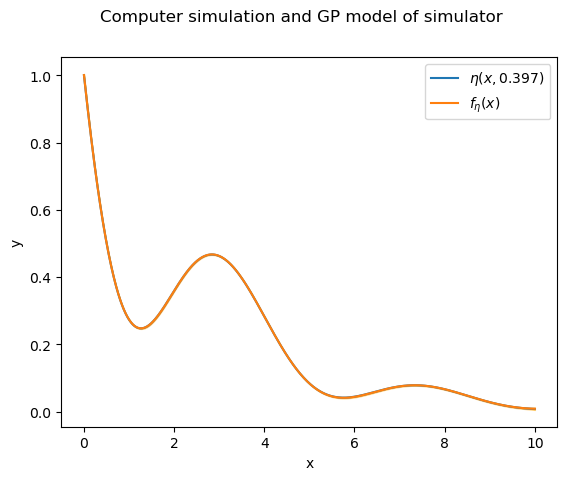

In [45]:
theta = params_transformed['theta']

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(x, eta(x, theta), label=fr'$\eta(x, {theta:.3f})$')
ax.plot(xpred, eta_pred_m, label=r'$f_\eta(x)$')
ax.fill_between(
    xpred, 
    eta_pred_m-1.96*eta_pred_sd, 
    eta_pred_m+1.96*eta_pred_sd, 
    alpha=0.5, 
    color='orange'
)
# ax.scatter(obs_x, obs_y, label="observations")

ax.legend()
fig.suptitle("Computer simulation and GP model of simulator")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

## Plot GP modelling true process

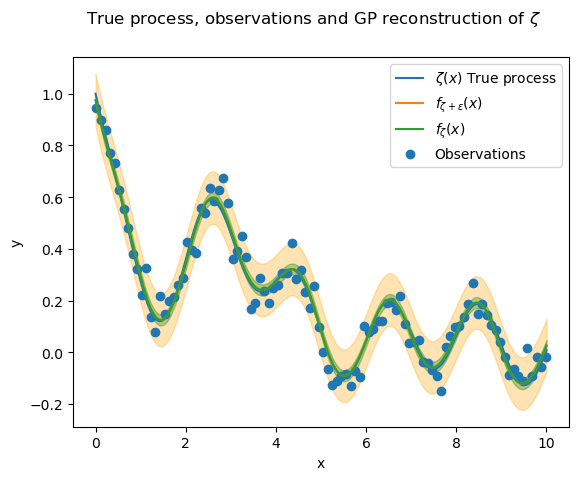

In [46]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(x, zeta(x)+disc(x), label=r'$\zeta(x)$ True process')
ax.plot(xpred, obs_pred_m, label=r'$f_{\zeta+\epsilon}(x)$')
ax.fill_between(
    xpred, 
    obs_pred_m-1.96*obs_pred_sd, 
    obs_pred_m+1.96*obs_pred_sd, 
    alpha=0.3, 
    color='orange'
)
ax.plot(xpred, zeta_pred_m, label=r'$f_{\zeta}(x)$')
ax.fill_between(
    xpred, 
    zeta_pred_m-1.96*zeta_pred_sd, 
    zeta_pred_m+1.96*zeta_pred_sd, 
    alpha=0.3, 
    color='green'
)
ax.scatter(dataloader.xf, dataloader.yf, label="Observations")

ax.legend()
fig.suptitle("True process, observations and GP reconstruction of $\zeta$")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

## Model discrepancy

Interpret the next figure as follows. "True discrepancy" is the actual difference between the functions used to generate the simulation output and the observations. The blue line is the function the code is trying to learn. According to the MCMC samples, $\delta(x)$ should be the blue line. $f_\delta(x)$ is the attempt to learn the blue line.

Notice the uncertainty of the GP is very large and always encompases the true discrepancy function, $0$ for all $x$.

In [47]:
delta_gp_m = zeta_pred_m - eta_pred_m
delta_gp_v = zeta_pred_v + eta_pred_v
delta_gp_sd = np.sqrt(delta_gp_v)

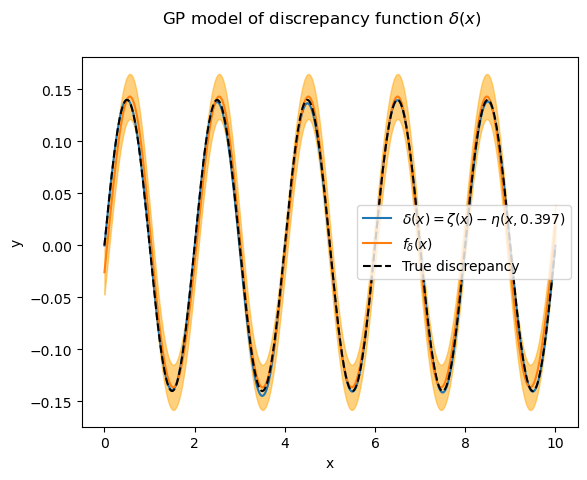

In [48]:
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.plot(x, zeta(x)+disc(x) - eta(x, theta), label=rf'$\delta(x) = \zeta(x) - \eta(x, {theta:.3f})$')
ax.plot(xpred, delta_gp_m, label=r'$f_\delta(x)$')
ax.fill_between(
    xpred, 
    delta_gp_m-1.96*delta_gp_sd, 
    delta_gp_m+1.96*delta_gp_sd, 
    alpha=0.5, 
    color='orange'
)
ax.plot(x, disc(x), color='black', linestyle='--', label='True discrepancy')

ax.legend()
fig.suptitle("GP model of discrepancy function $\delta(x)$")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()